In [1]:
import sys
import os

import joblib
import numpy as np
import pandas as pd

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, train_val_split, get_dimensions, scale, metrics_r, get_device, \
    plot_history, load_best_params, plot_mlp_comparison, d_types_methods, get_color_map, evaluate, \
    plot_prediction_scores, get_result_subsets, print_top_1, plot_true_vs_pred, get_results_table, print_info_features, \
    read_target_tensors, print_info_targets, get_chronology_table, plot_true_vs_pred_chronology

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, predict, activation_funcs, predict_mc

## Settings

In [5]:
# Current Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [6]:
# Data Path
path_features = os.path.abspath(os.path.join(os.getcwd(), "../../../data/features2"))
path_targets = os.path.abspath(os.path.join(os.getcwd(), "../../../data/targets/regression"))

# Model Path
path_models = os.path.abspath(os.path.join(os.getcwd(), "models"))
model_name = "pottery_chronology_regressor_"

In [7]:
# Targets
targets = ["StartYear", "YearRange"]

In [8]:
# Evaluation Metrics
criterion = nn.MSELoss()
metrics = metrics_r

## Data

### Read Features and Targets

In [9]:
X = read_features(path_features, f_type="tensors")
print_info_features(X)

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_val_tfidf
Loaded X_val_bert
Loaded X_val_cannyhog
Loaded X_val_resnet
Loaded X_val_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<

In [10]:
y = read_target_tensors(path_targets)
print_info_targets(y)

Loaded y_train
Loaded y_val
Loaded y_test
{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1528, 2])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191, 2])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191, 2])
}


### Load Target Scaler

In [11]:
path_scaler = os.path.join(path_targets, "y_scaler.pkl")
y_scaler = joblib.load(path_scaler)

### Get Dimensions

In [12]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


### Torch Datasets and Dataloaders

In [13]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

### Target to Numpy for comparing Predictions

In [14]:
y = {subset: y_scaler.inverse_transform(_y.cpu().numpy()) for subset, _y in y.items()}

print_info_targets(y)

{
	train: 
		<class 'numpy.ndarray'>
		shape   = (1528, 2)
	val: 
		<class 'numpy.ndarray'>
		shape   = (191, 2)
	test: 
		<class 'numpy.ndarray'>
		shape   = (191, 2)
}


## Best Params from Tuning

In [15]:
# Load Saved Best Params
path_params = os.path.join(path_models, "best_params.json")
best_params = load_best_params(path_params)

## Text Input MLP Model

### Rebuild Model

In [16]:
ft = "tfidf"
params = best_params[ft]["params"]
pd.Series(params, name="value")

activation                   relu
blocks                          3
dropout                       0.1
hidden_size                   256
hidden_size_pattern    decreasing
lr                           0.01
Name: value, dtype: object

In [17]:
model_txt = PotteryChronologyPredictor(
    [X_dim[ft]],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="years"
)

model_txt.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─ReLU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3                 [1, 256]                  [1, 256]                  --                        --
├─Sequential: 1-2                        [1, 256]                  [1, 2]                    --                        --
│    └─Linear

### Load Weights

In [18]:
path_model = os.path.join(path_models, f"{model_name}{ft}.pt")
print(path_model)
model_txt.load_state_dict(torch.load(path_model, weights_only=True))
model_txt.eval()

print(f"✅ Loaded {ft.upper()}-Input Model. Ready for testing!")

C:\Users\dimit\PycharmProjects\AgoraPottery\02_chronology_prediction\NN\regression2\models\pottery_chronology_regressor_tfidf.pt
✅ Loaded TFIDF-Input Model. Ready for testing!


### Predict Test Set

In [19]:
y_pred, y_std = predict_mc(model_txt, loaders["test"][ft], y_scaler, mc_samples=50)

[Test]: 100%|██████████| 3/3 [00:00<00:00, 65.25it/s]





TARGET: StartYear




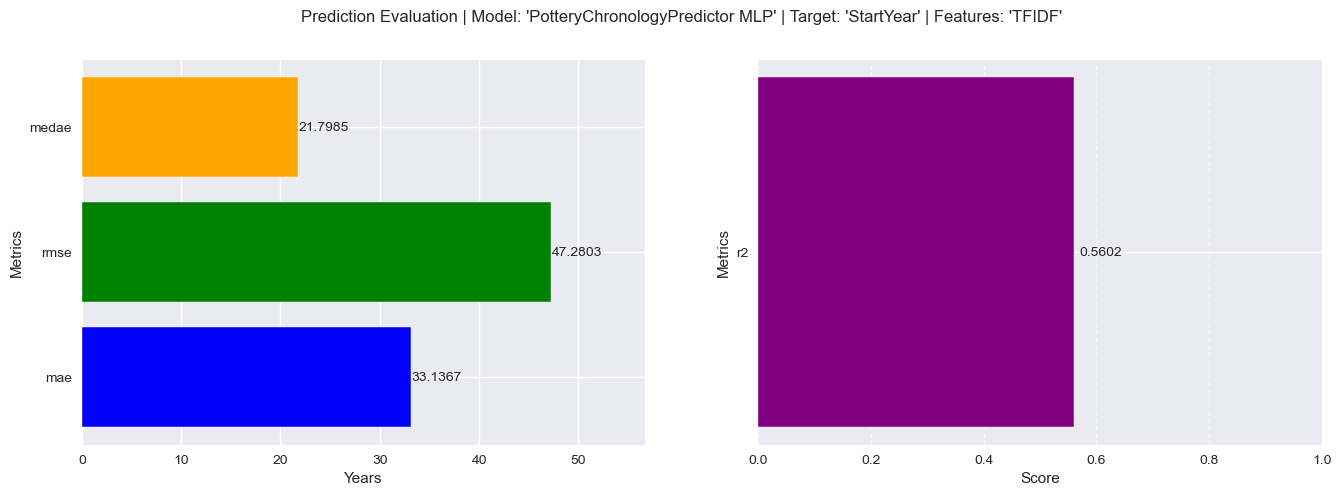



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,-525.0,-515.550293,10.443358,-536.019275,-495.081311,9.449707
130,BEST,-500.0,-500.286530,8.114888,-516.191711,-484.381348,0.286530
30,WORST,-600.0,-432.360199,12.984163,-457.809158,-406.911240,167.639801


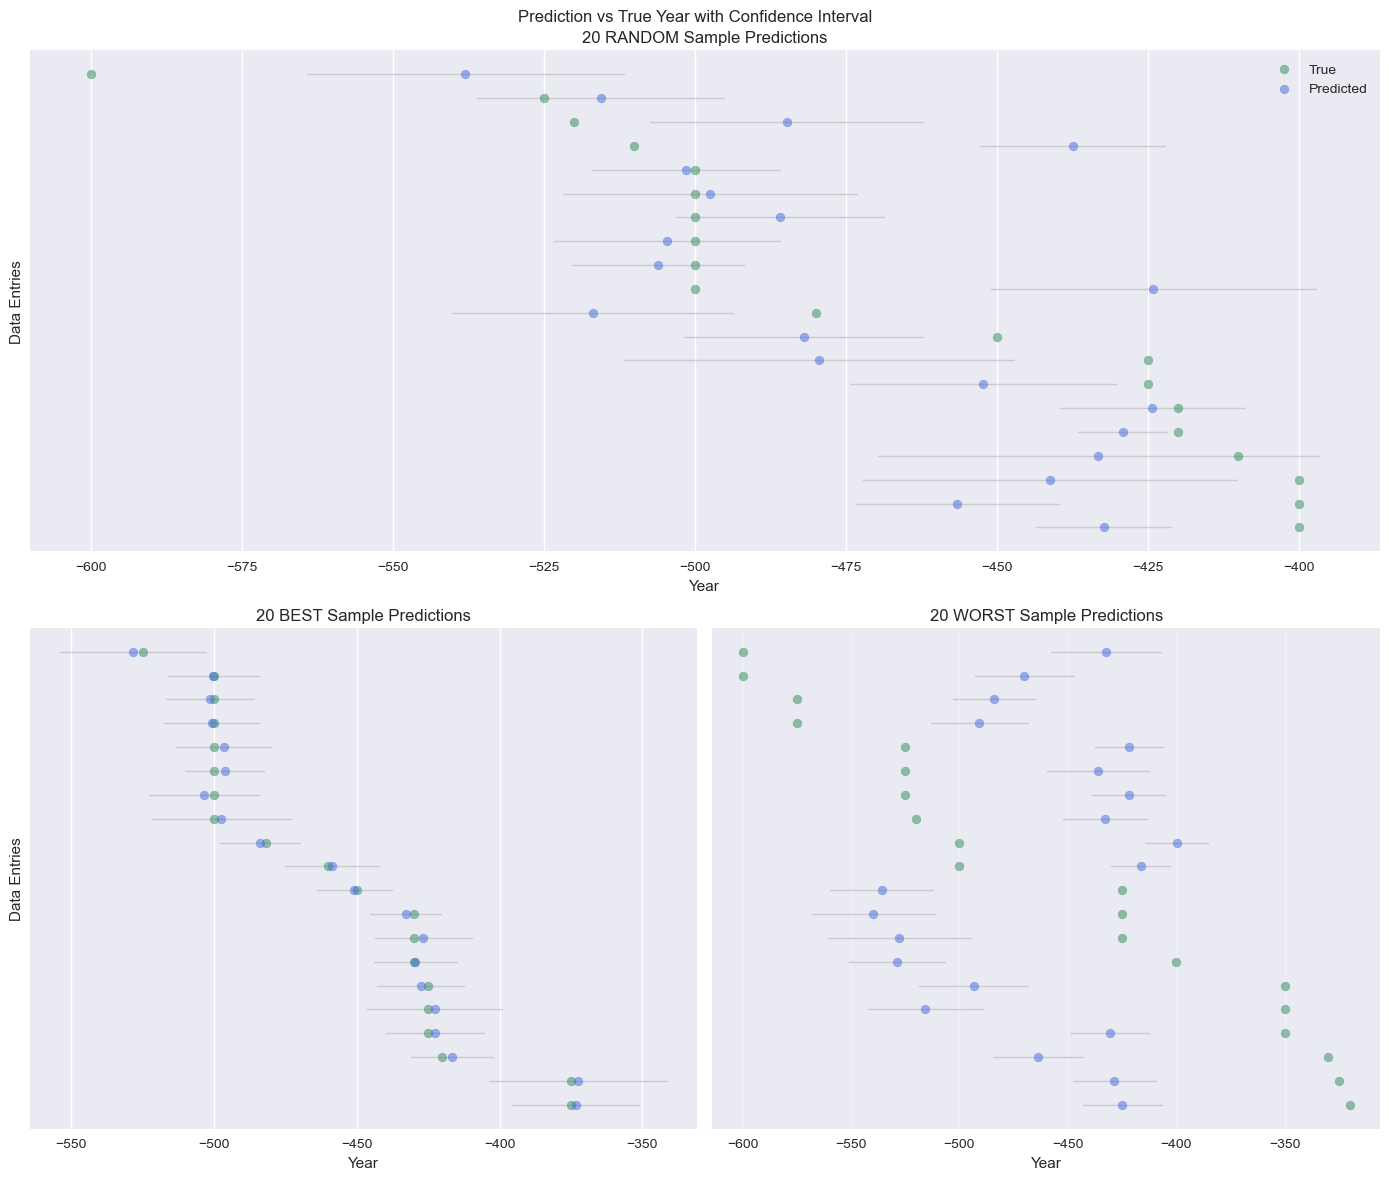




TARGET: YearRange




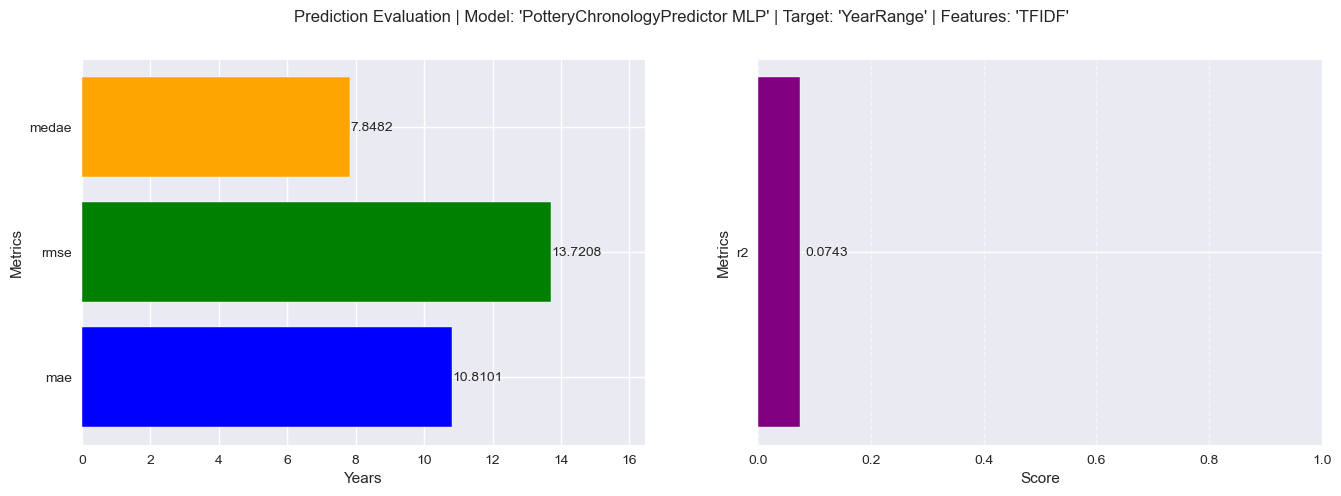



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,25.0,7.362910,2.934525,1.611241,13.114579,17.637091
120,BEST,15.0,15.035394,3.564291,8.049384,22.021404,0.035394
68,WORST,50.0,8.491794,3.269866,2.082857,14.900731,41.508205


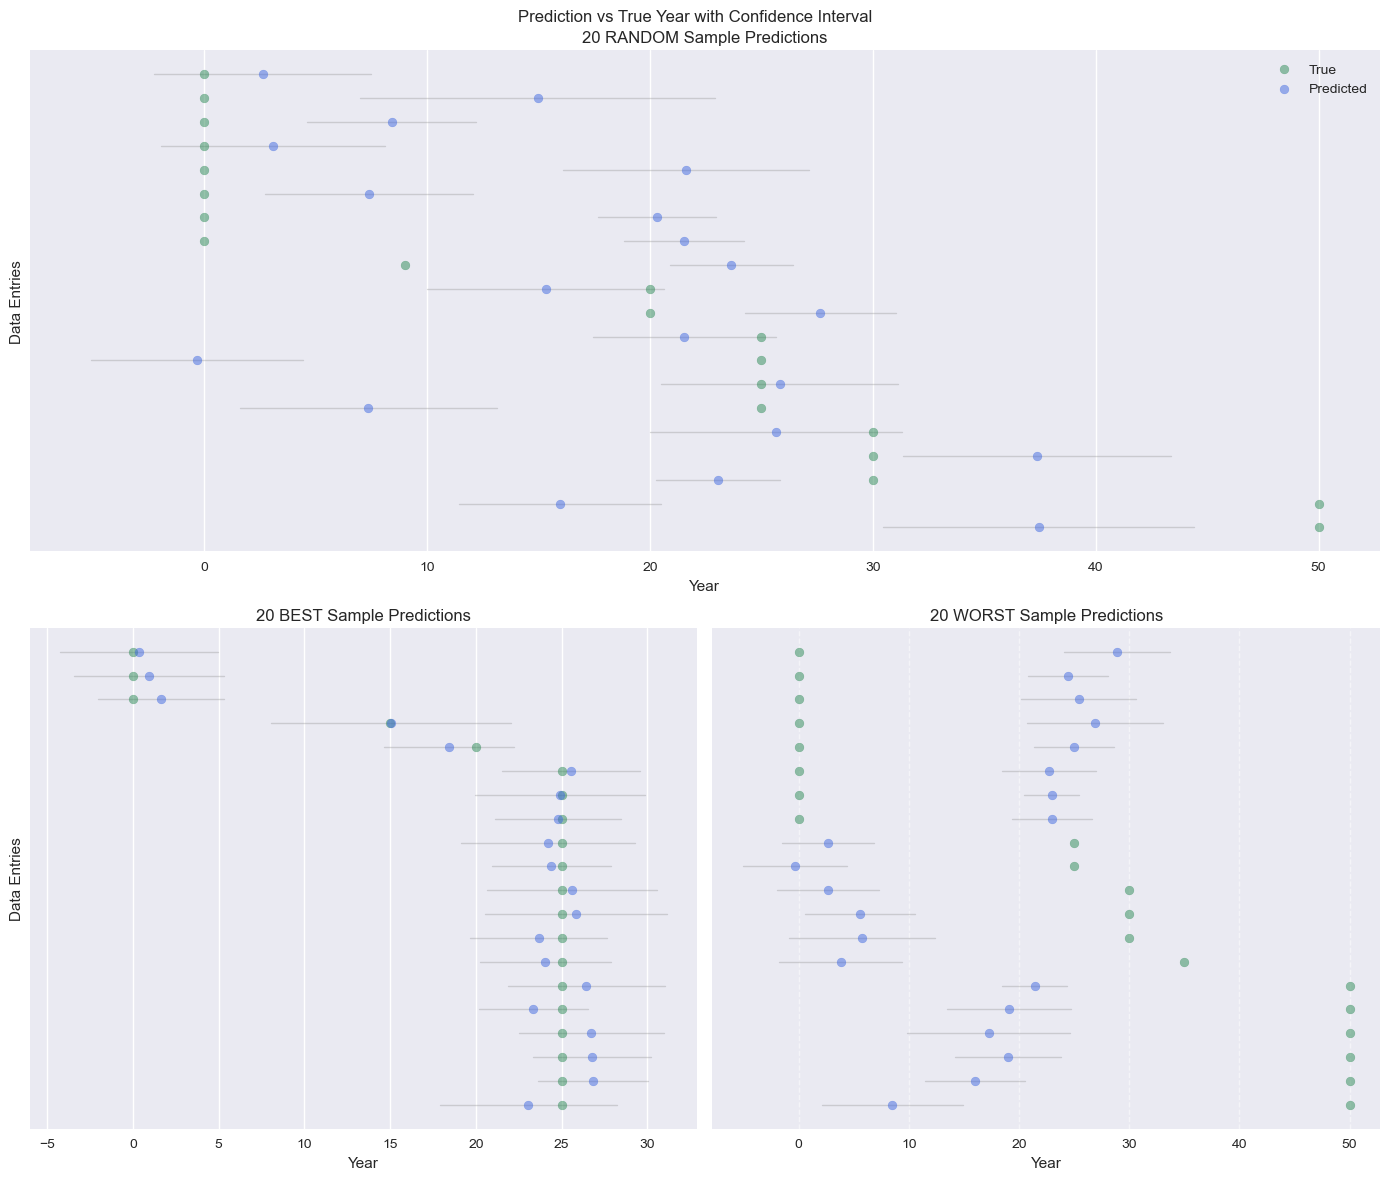




TOTAL CHRONOLOGY


Example Sample Predictions:


,SAMPLE,start_year_pred,end_year_pred,start_year_true,end_year_true,error
152,RANDOM,-516.0,-509.0,-525.0,-500.0,9.0
130,BEST,-500.0,-476.0,-500.0,-475.0,0.5
30,WORST,-432.0,-405.0,-600.0,-575.0,169.0


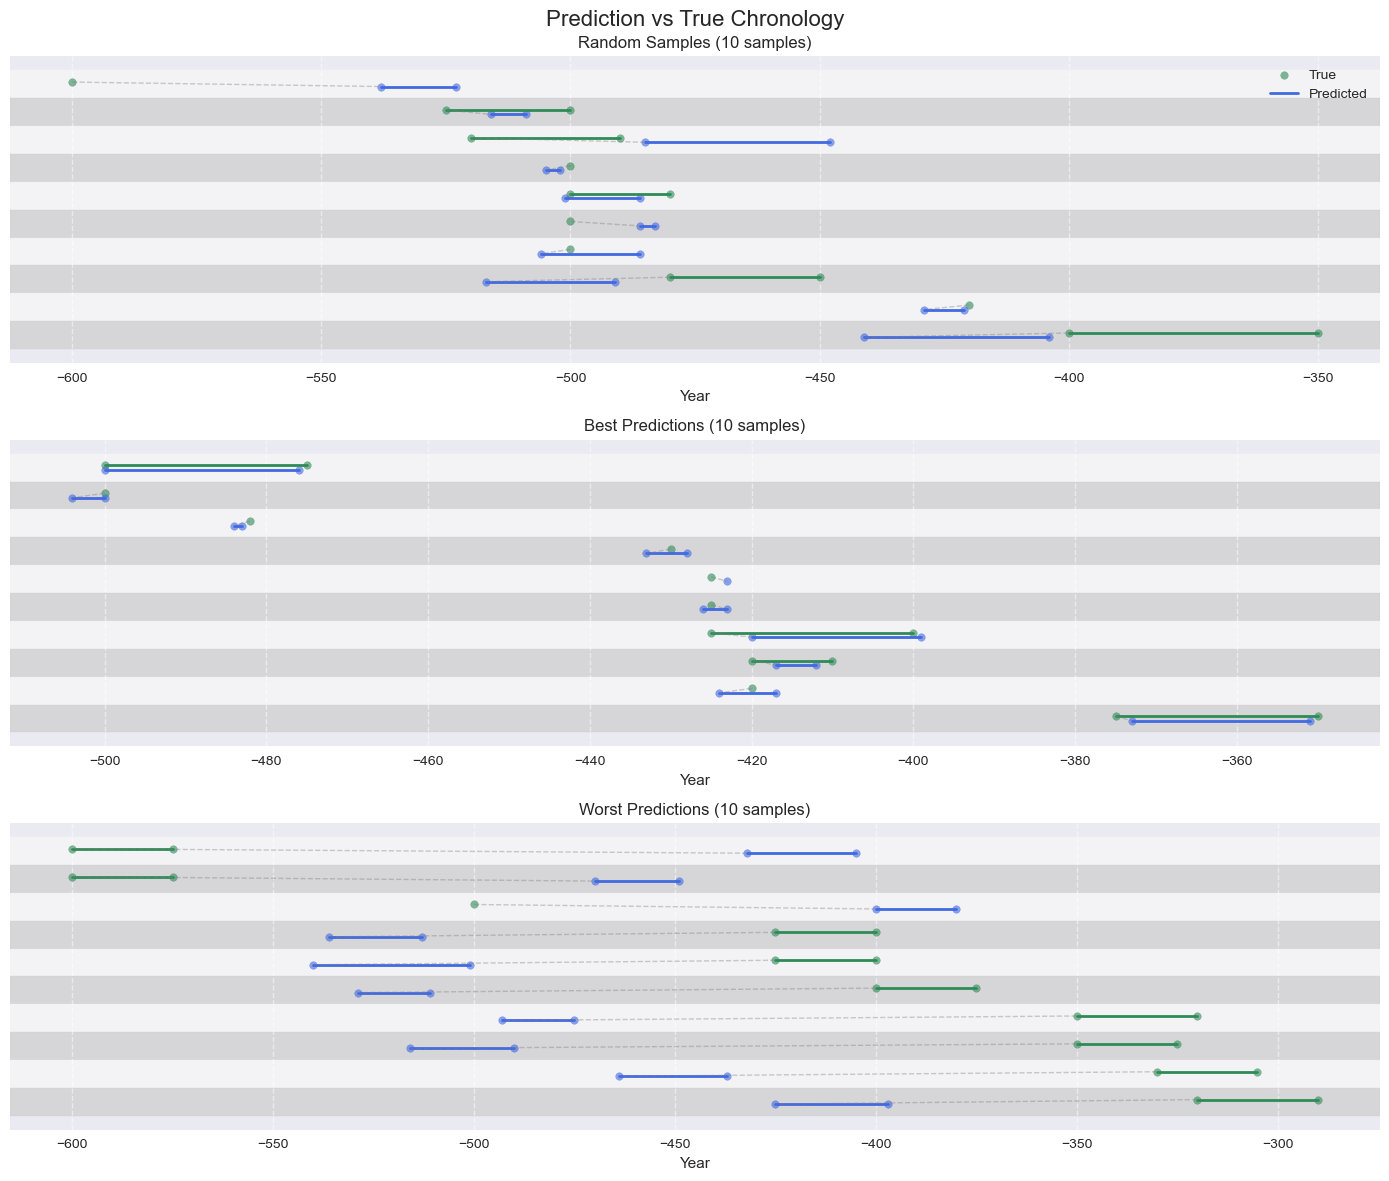

In [20]:
for t, target in enumerate(targets):
    print(f"\n\n\nTARGET: {target}")

    results = get_results_table(y["test"][:, t], y_pred[:, t], y_std[:, t])

    # Evaluate
    scores = evaluate(results["y_true"], results["prediction"], metrics_r)
    plot_prediction_scores(scores, "PotteryChronologyPredictor MLP", target, ft)

    # Predictions Close Look
    result_subsets = get_result_subsets(results, samples=20)
    print_top_1(result_subsets)
    plot_true_vs_pred(result_subsets)

# Total Chronology Range
print(f"\n\n\nTOTAL CHRONOLOGY")
chron_table = get_chronology_table(y["test"], y_pred)
chron_subsets = get_result_subsets(chron_table, samples=10)
print_top_1(chron_subsets)
plot_true_vs_pred_chronology(chron_subsets)

## Image Input MLP Model

### Rebuild Model

In [21]:
ft = "vit"
params = best_params[ft]["params"]
pd.Series(params, name="value")

activation                 relu
blocks                        3
dropout                     0.2
hidden_size                 512
hidden_size_pattern    constant
lr                        0.005
Name: value, dtype: object

In [22]:
model_img = PotteryChronologyPredictor(
    [X_dim[ft]],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="years"
)

model_txt.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─ReLU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3                 [1, 256]                  [1, 256]                  --                        --
├─Sequential: 1-2                        [1, 256]                  [1, 2]                    --                        --
│    └─Linear

### Load Weights

In [23]:
path_model = os.path.join(path_models, f"{model_name}{ft}.pt")
model_img.load_state_dict(torch.load(path_model, weights_only=True))
model_img.eval()

print(f"✅ Loaded {ft.upper()}-Input Model. Ready for testing!")

✅ Loaded VIT-Input Model. Ready for testing!


### Predict Test Set

In [24]:
y_pred, y_std = predict_mc(model_img, loaders["test"][ft], y_scaler, mc_samples=50)

[Test]: 100%|██████████| 3/3 [00:00<00:00, 69.98it/s]





TARGET: StartYear




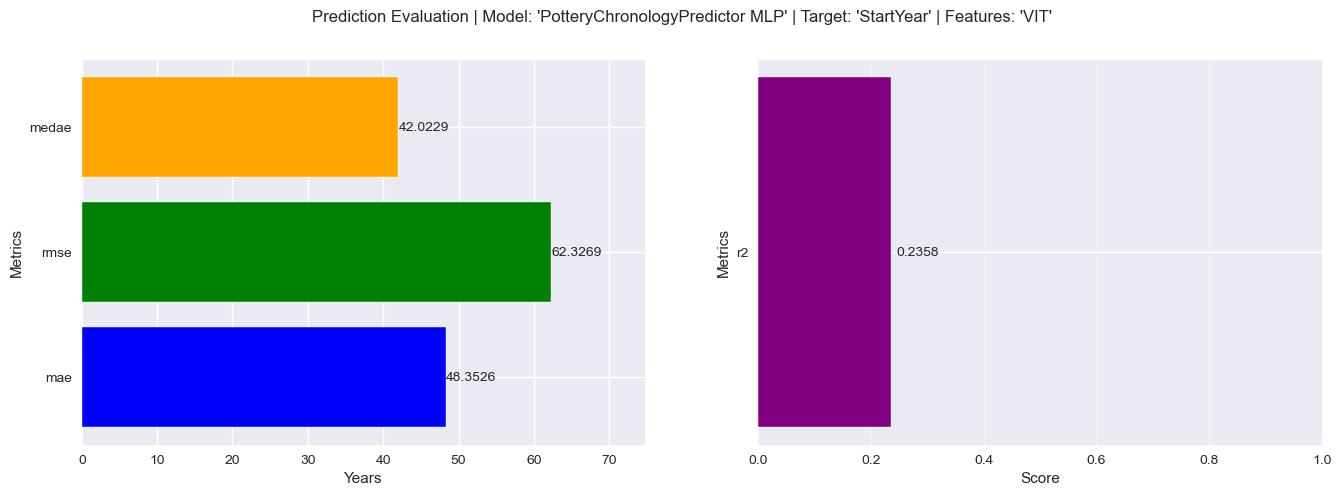



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,-525.0,-554.161926,25.417977,-603.981161,-504.342692,29.161926
80,BEST,-500.0,-500.658569,19.697658,-539.265979,-462.051160,0.658569
49,WORST,-575.0,-390.619659,17.414123,-424.751341,-356.487977,184.380341


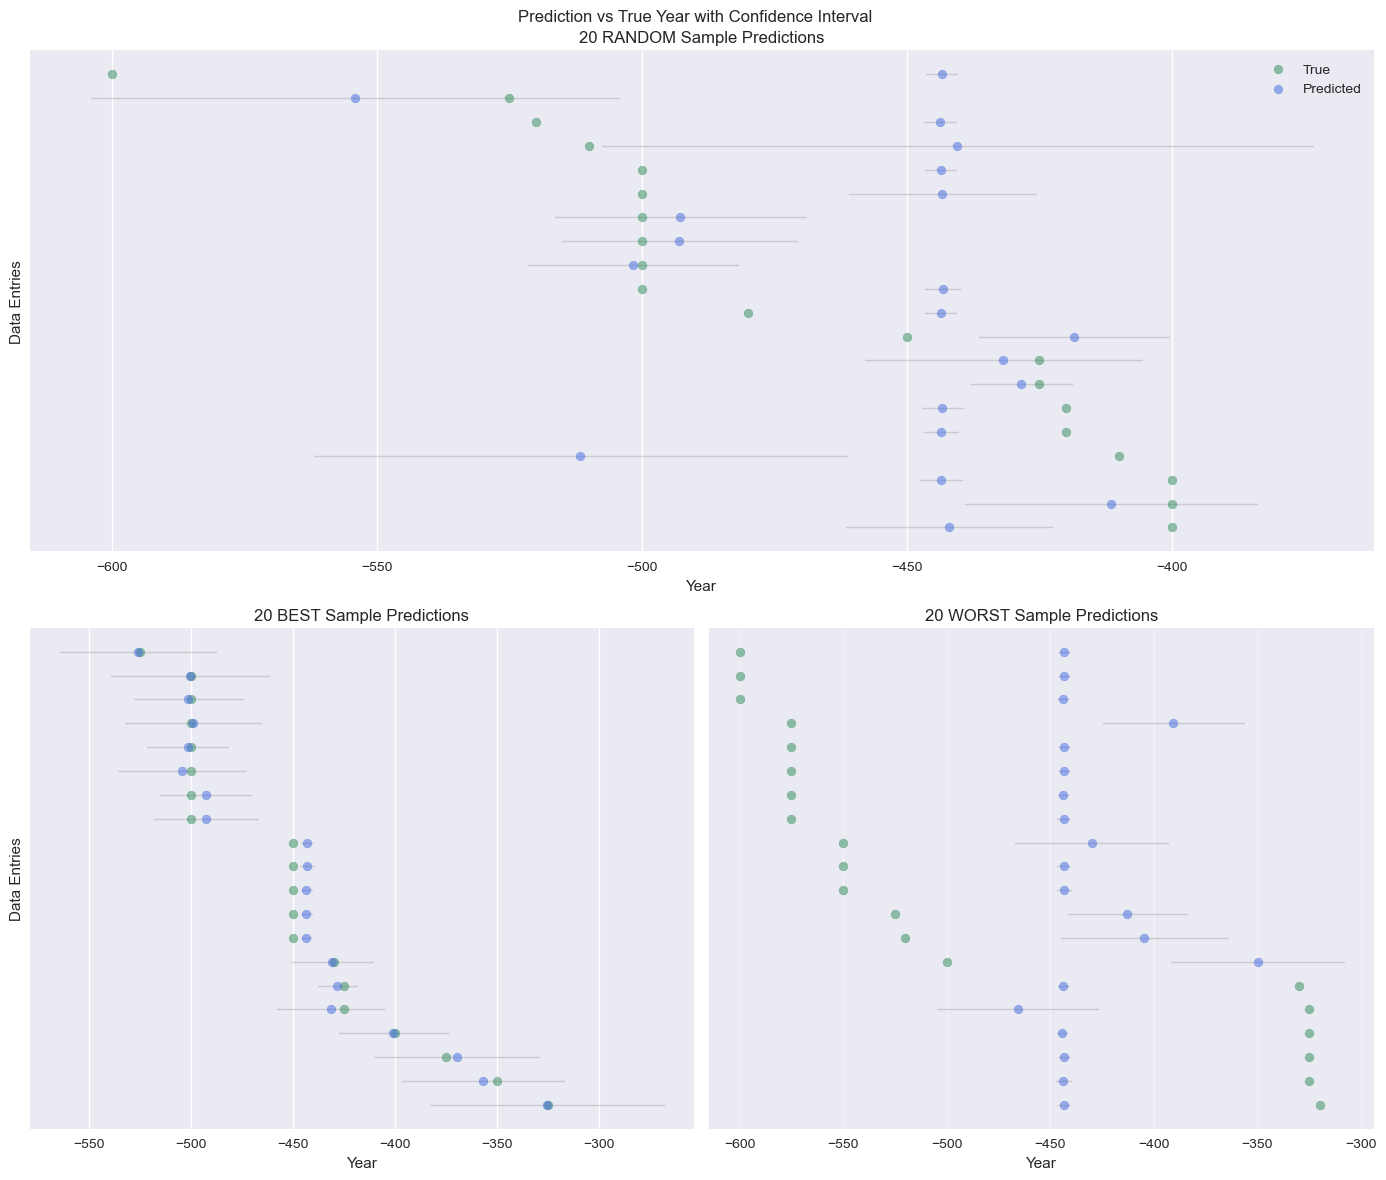




TARGET: YearRange




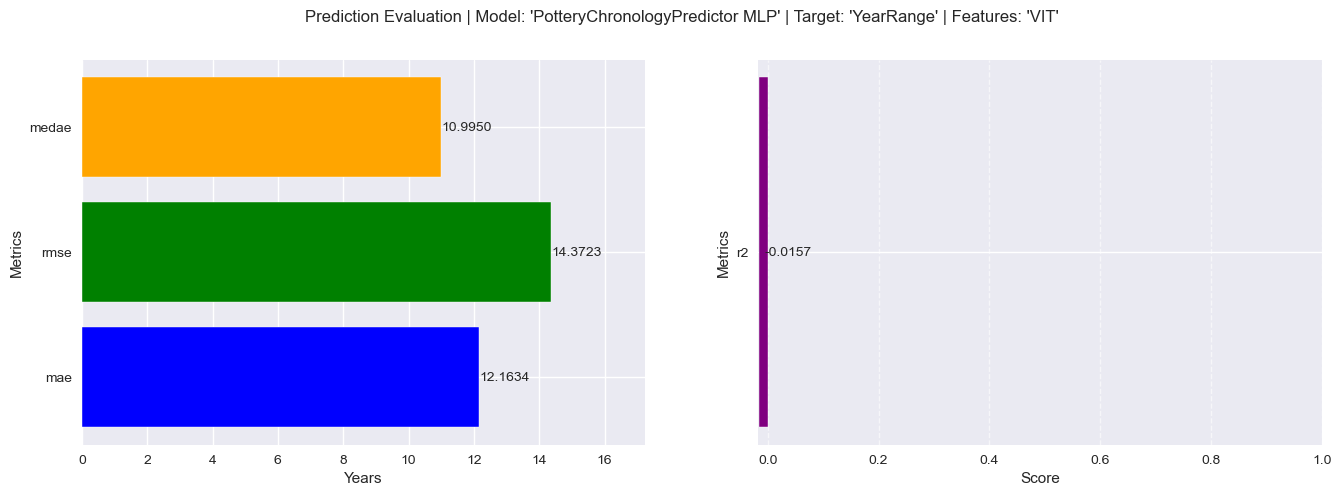



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,25.0,10.297455,2.605754,5.190178,15.404732,14.702545
56,BEST,10.0,10.060056,1.795265,6.541335,13.578776,0.060056
83,WORST,50.0,16.198748,0.257157,15.694719,16.702776,33.801254


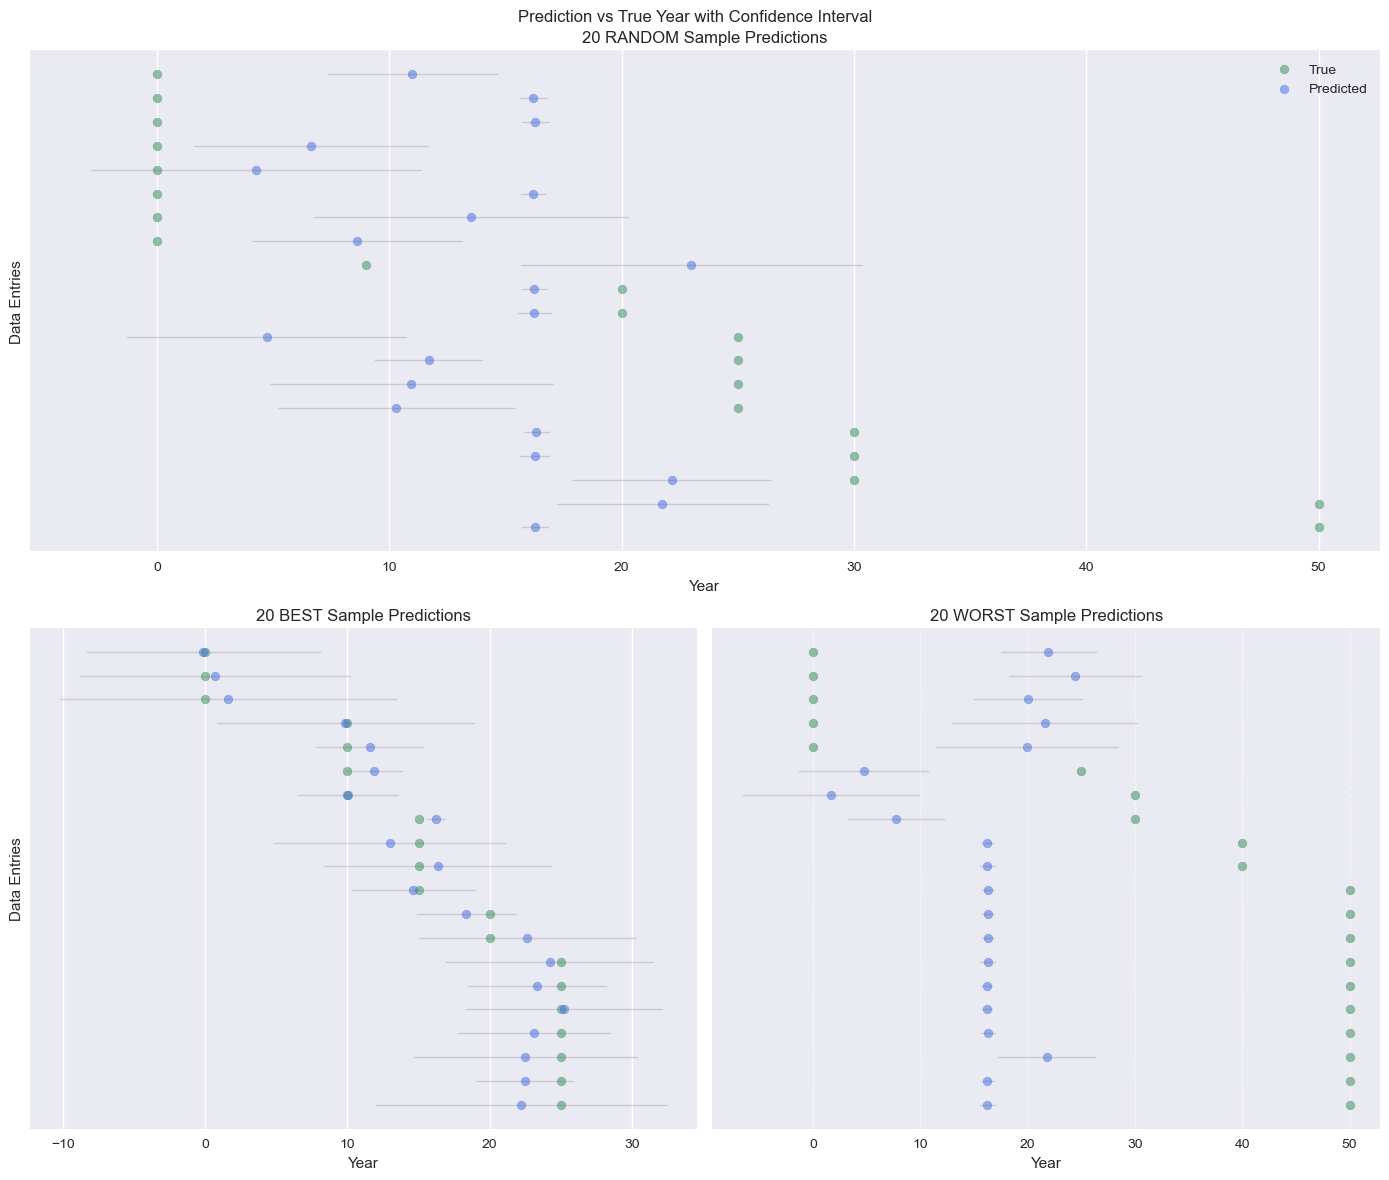




TOTAL CHRONOLOGY


Example Sample Predictions:


,SAMPLE,start_year_pred,end_year_pred,start_year_true,end_year_true,error
152,RANDOM,-554.0,-544.0,-525.0,-500.0,36.5
64,BEST,-499.0,-498.0,-500.0,-500.0,1.5
49,WORST,-391.0,-374.0,-575.0,-540.0,175.0


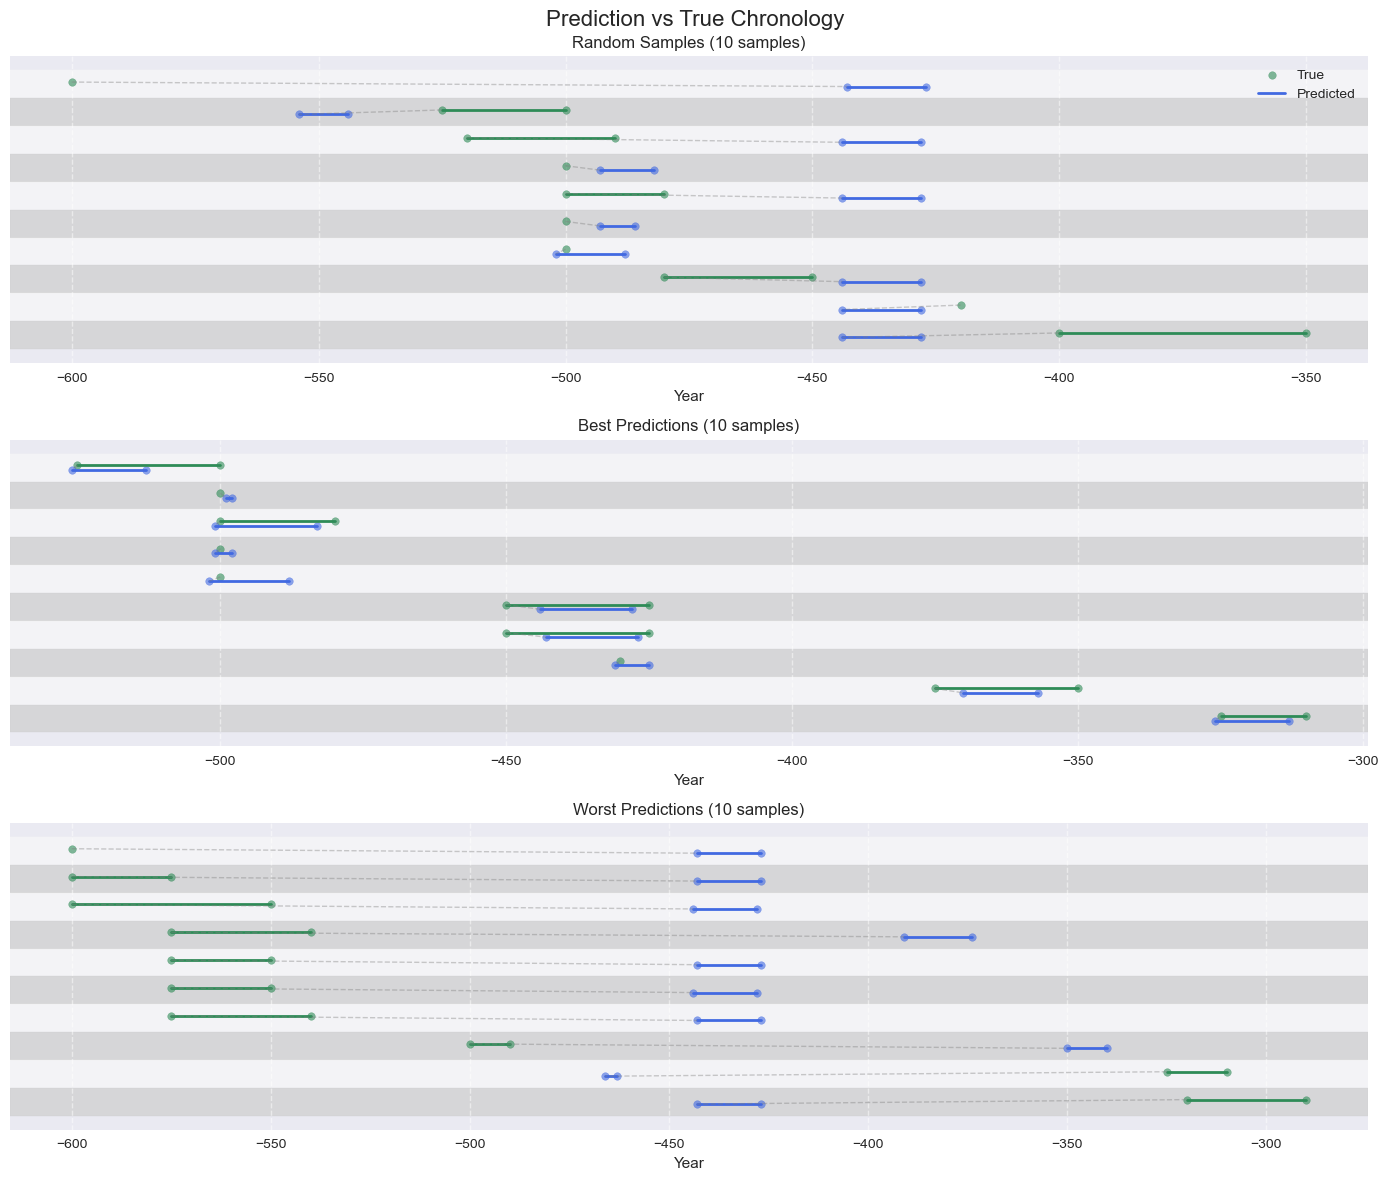

In [25]:
for t, target in enumerate(targets):
    print(f"\n\n\nTARGET: {target}")

    results = get_results_table(y["test"][:, t], y_pred[:, t], y_std[:, t])

    # Evaluate
    scores = evaluate(results["y_true"], results["prediction"], metrics_r)
    plot_prediction_scores(scores, "PotteryChronologyPredictor MLP", target, ft)

    # Predictions Close Look
    result_subsets = get_result_subsets(results, samples=20)
    print_top_1(result_subsets)
    plot_true_vs_pred(result_subsets)

# Total Chronology Range
print(f"\n\n\nTOTAL CHRONOLOGY")
chron_table = get_chronology_table(y["test"], y_pred)
chron_subsets = get_result_subsets(chron_table, samples=10)
print_top_1(chron_subsets)
plot_true_vs_pred_chronology(chron_subsets)

## Text + Image Combo Input MLP Model

### Build Model

In [26]:
fts = ["tfidf", "vit"]
ft = " + ".join(fts)
params = best_params[ft]["params"]
pd.Series(params, name="value")

activation                 relu
blocks                        2
dropout                     0.1
hidden_size                 512
hidden_size_pattern    constant
lr                        0.005
Name: value, dtype: object

In [27]:
model_cmb = PotteryChronologyPredictor(
    [X_dim[_ft] for _ft in fts],
    y_dim,
    params["hidden_size"],
    device=device,
    activation=activation_funcs[params["activation"]],
    dropout=params["dropout"],
    blocks=params["blocks"],
    hidden_size_pattern=params["hidden_size_pattern"],
    chronology_target="years"
)

model_img.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 768]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 768]                  [1, 512]                  --                        --
│    │    └─Linear: 3-1                  [1, 768]                  [1, 512]                  393,728                   393,728
│    │    └─ReLU: 3-2                    [1, 512]                  [1, 512]                  --                        --
│    │    └─Dropout: 3-3                 [1, 512]                  [1, 512]                  --                        --
├─Sequential: 1-2                        [1, 512]                  [1, 2]                    --                        --
│    └─Linea

### Load Weights

In [28]:
path_model = os.path.join(path_models, f"{model_name}{"_".join(fts)}.pt")
model_cmb.load_state_dict(torch.load(path_model, weights_only=True))
model_cmb.eval()

print(f"✅ Loaded {ft.upper()}-Input Model. Ready for testing!")

✅ Loaded TFIDF + VIT-Input Model. Ready for testing!


### Predict Test Set

In [29]:
y_pred, y_std = predict_mc(model_cmb, loaders["test"][ft], y_scaler, mc_samples=50)

[Test]: 100%|██████████| 3/3 [00:00<00:00, 48.07it/s]





TARGET: StartYear




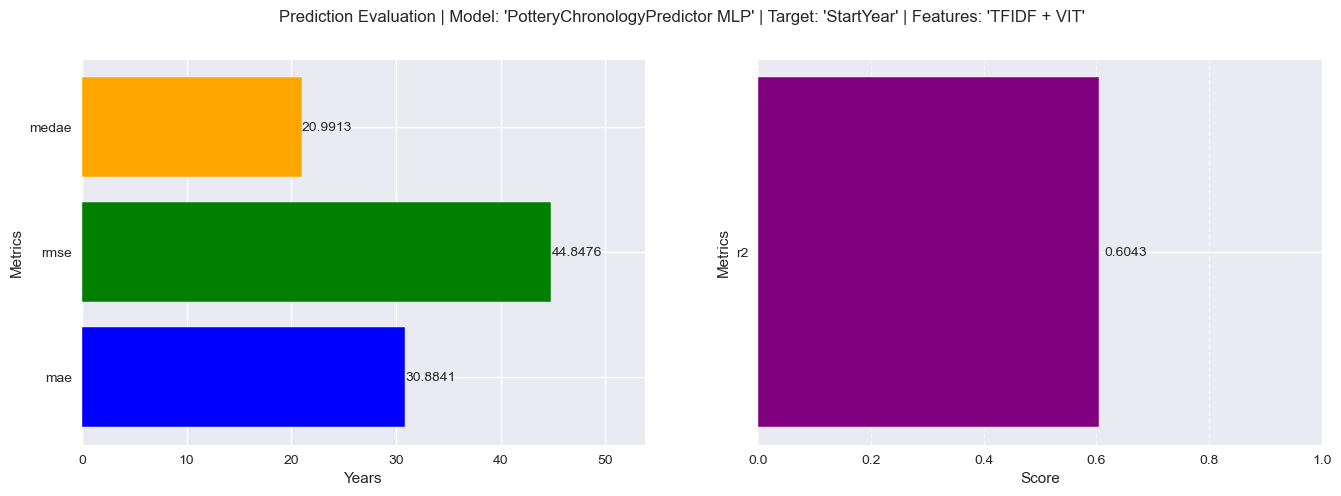



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,-525.0,-548.473877,10.243082,-568.550318,-528.397436,23.473877
4,BEST,-550.0,-550.211365,7.732879,-565.367807,-535.054923,0.211365
108,WORST,-350.0,-522.614807,11.430586,-545.018756,-500.210859,172.614807


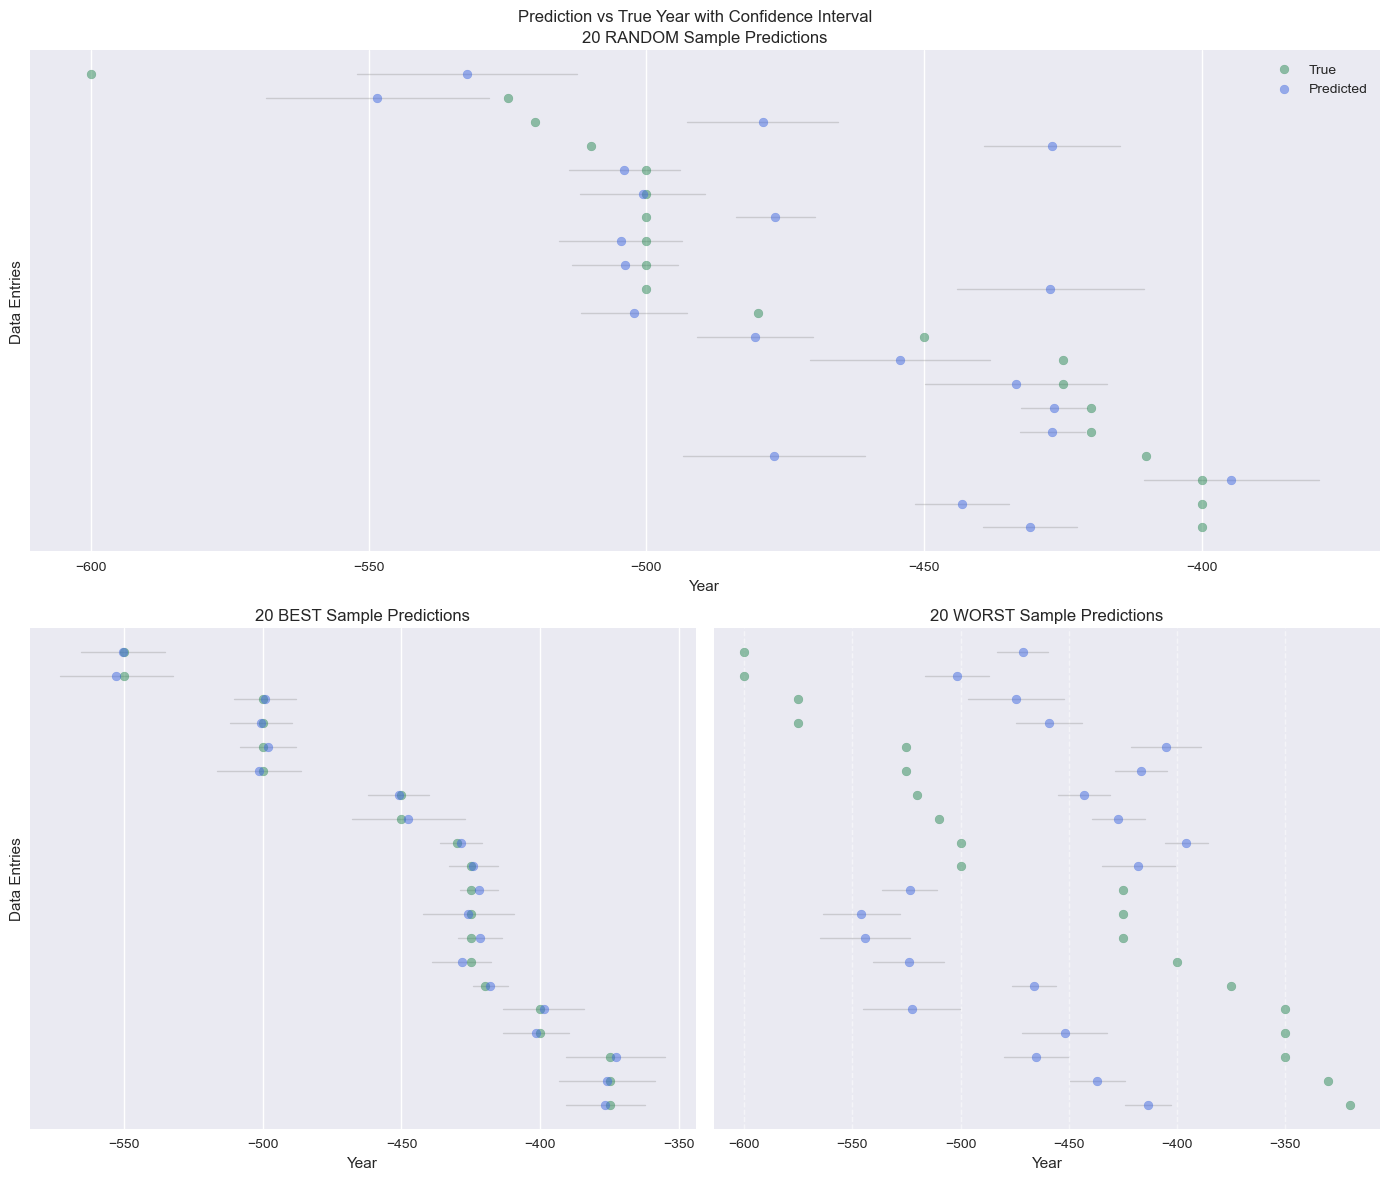




TARGET: YearRange




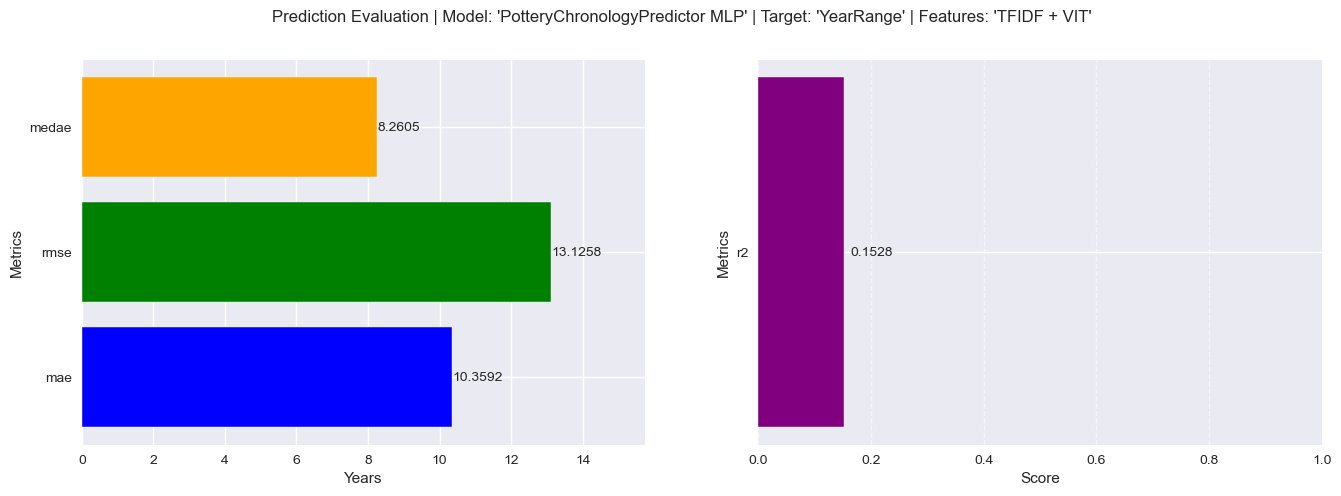



Example Sample Predictions:


,SAMPLE,y_true,y_pred,y_std,CI_lower,CI_upper,error
152,RANDOM,25.0,16.697971,2.058092,12.664112,20.731831,8.302029
167,BEST,25.0,24.921303,2.204416,20.600648,29.241958,0.078697
68,WORST,50.0,4.980970,1.038990,2.944550,7.017390,45.019032


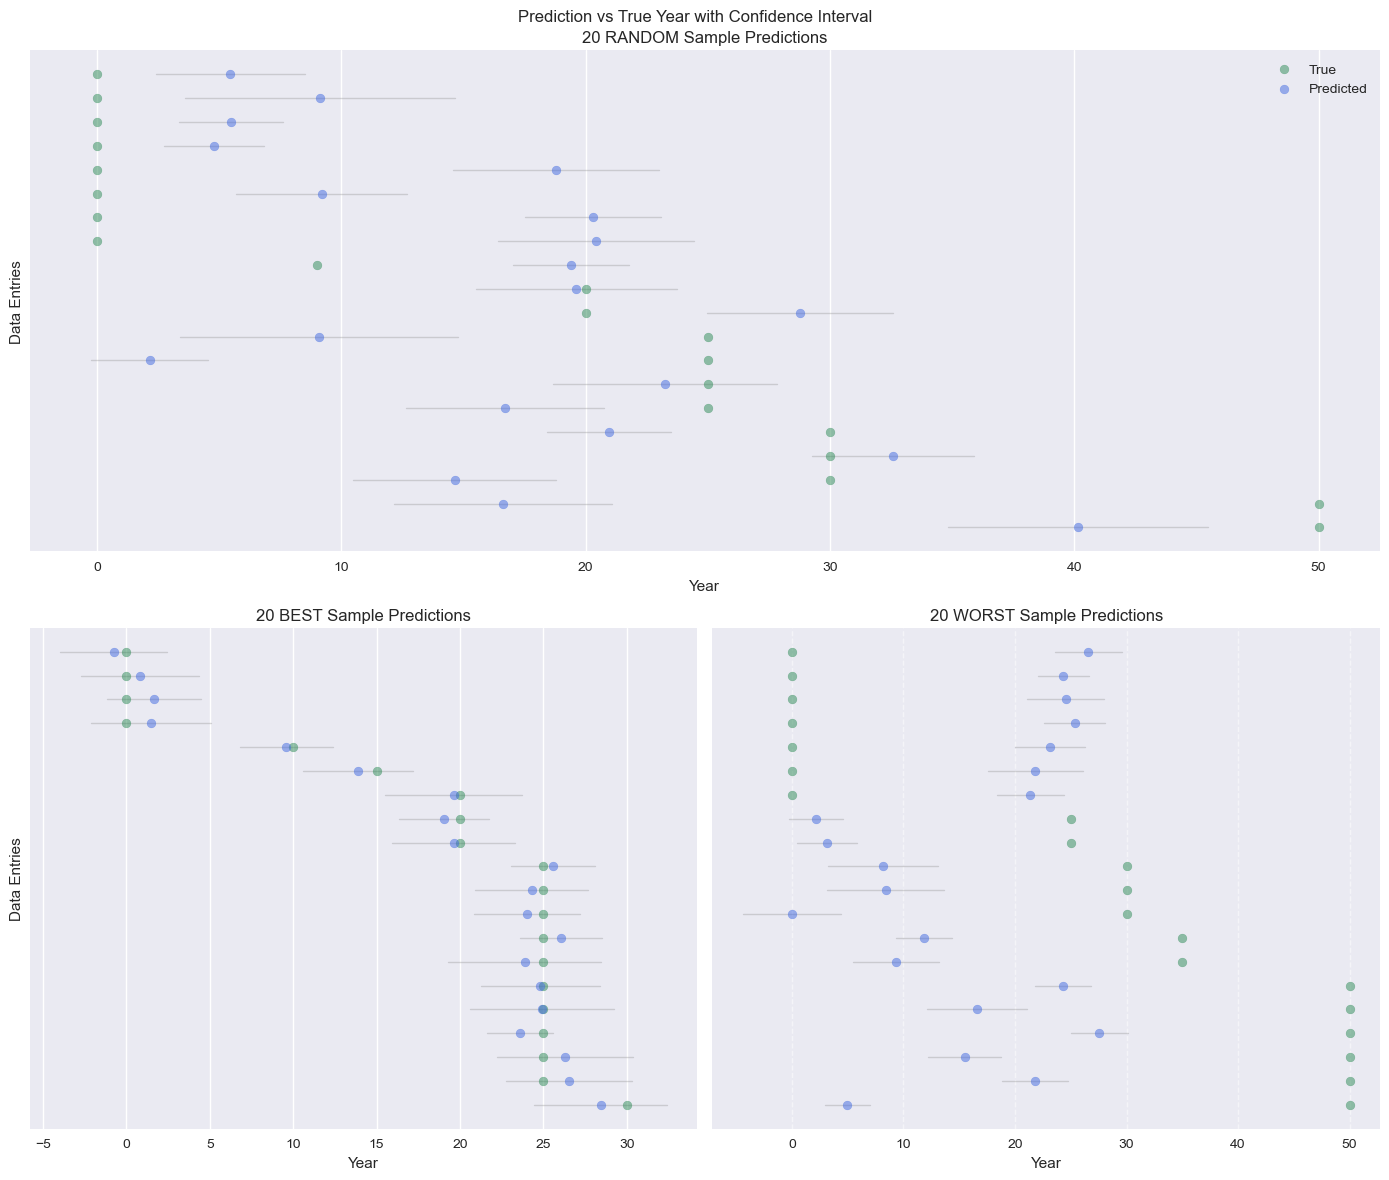




TOTAL CHRONOLOGY


Example Sample Predictions:


,SAMPLE,start_year_pred,end_year_pred,start_year_true,end_year_true,error
152,RANDOM,-548.0,-531.0,-525.0,-500.0,27.0
144,BEST,-401.0,-391.0,-400.0,-390.0,1.0
108,WORST,-523.0,-501.0,-350.0,-325.0,174.5


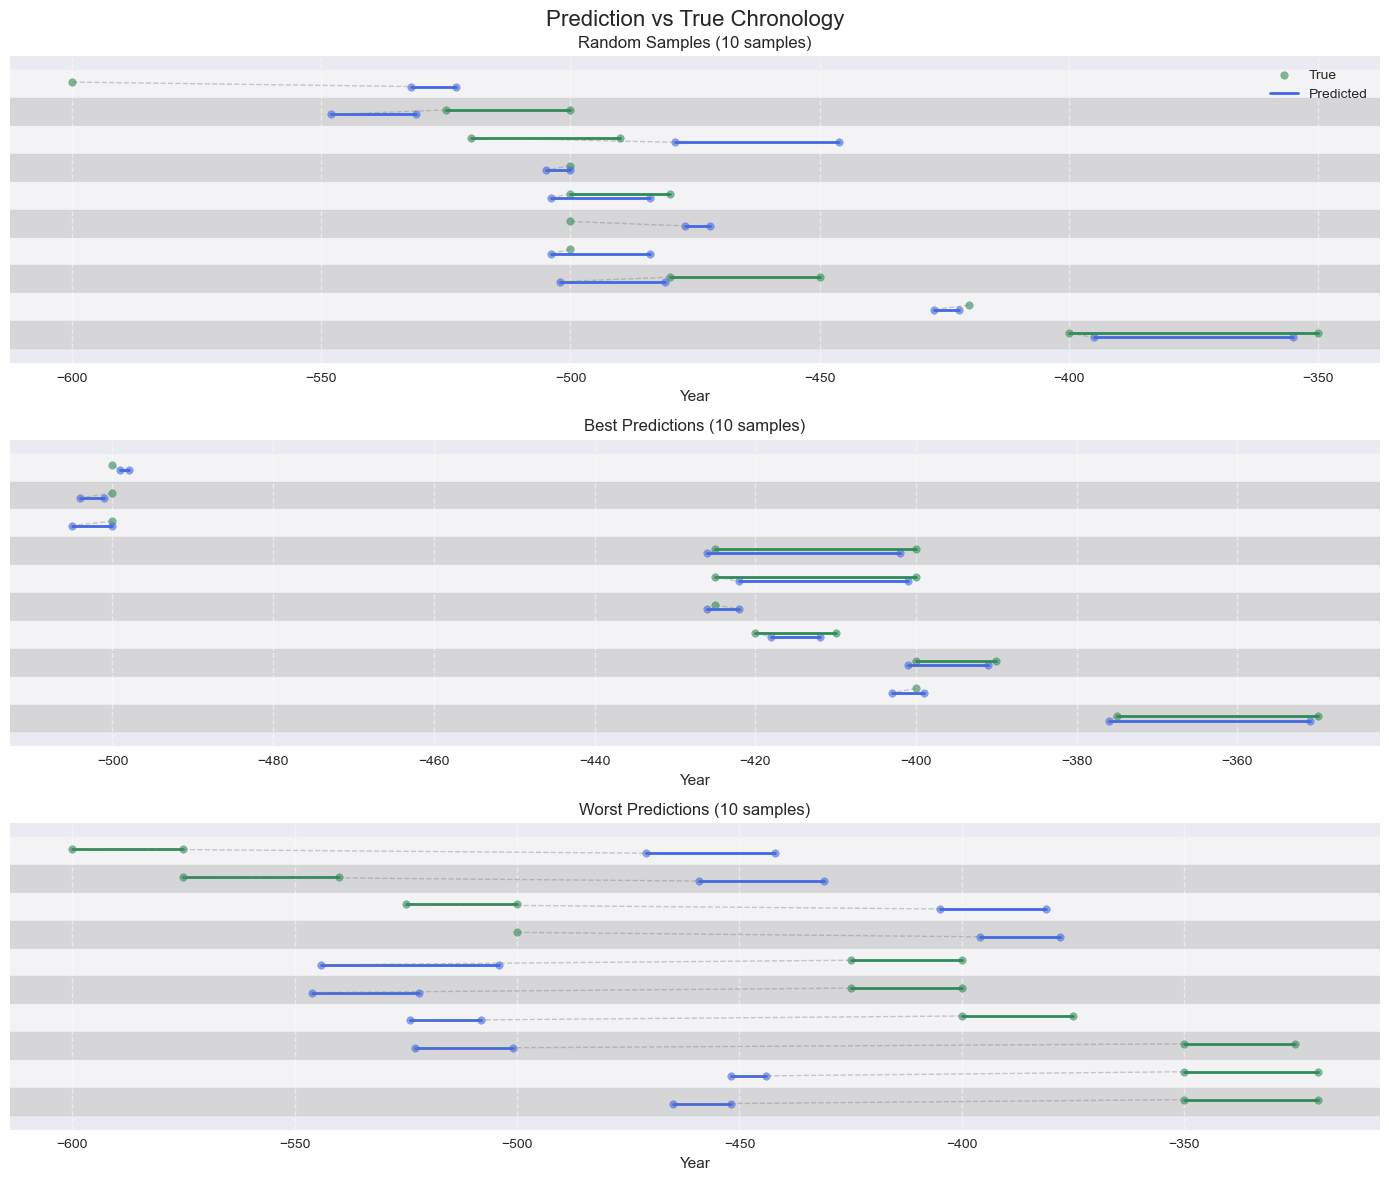

In [30]:
for t, target in enumerate(targets):
    print(f"\n\n\nTARGET: {target}")

    results = get_results_table(y["test"][:, t], y_pred[:, t], y_std[:, t])

    # Evaluate
    scores = evaluate(results["y_true"], results["prediction"], metrics_r)
    plot_prediction_scores(scores, "PotteryChronologyPredictor MLP", target, ft)

    # Predictions Close Look
    result_subsets = get_result_subsets(results, samples=20)
    print_top_1(result_subsets)
    plot_true_vs_pred(result_subsets)

# Total Chronology Range
print(f"\n\n\nTOTAL CHRONOLOGY")
chron_table = get_chronology_table(y["test"], y_pred)
chron_subsets = get_result_subsets(chron_table, samples=10)
print_top_1(chron_subsets)
plot_true_vs_pred_chronology(chron_subsets)